<a href="https://colab.research.google.com/github/clementine0421/Yuting-Liu/blob/master/Image-processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import sys
import time
import os
import math
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [3]:
## Code Cell 1.2

# Load training data
transform_train = transforms.Compose([                                   
    transforms.RandomCrop(32, padding=4), #剪切图片大小                                      
    transforms.RandomHorizontalFlip(),#把图片上下翻转，增加图片的变化
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),#把数据变成有正有负的
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True,
                                        transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

# Load testing data
transform_test = transforms.Compose([                                           
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True,
                                       transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, #Batch szie :一次取128张图片
                                         num_workers=2)
print('Finished loading datasets!')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Finished loading datasets!


In [0]:
def conv_block(in_channels, out_channels, kernel_size=3, stride=1,#新建block，卷积+batch norm+relu 组成conv模块
               padding=1):
    '''
    A nn.Sequential layer executes its arguments in sequential order. In
    this case, it performs Conv2d -> BatchNorm2d -> ReLU. This is a typical
    block of layers used in Convolutional Neural Networks (CNNs). The 
    ConvNet implementation below stacks multiple instances of this three layer
    pattern in order to achieve over 90% classification accuracy on CIFAR-10.
    '''
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding,
                  bias=False),
        # Implement: add Batch Normalization layer and ReLU here
        nn.BatchNorm2d(out_channels), #batch norm 把任意一个分布转为0，1分布
        nn.ReLU()
        )

class ConvNet(nn.Module):
    '''
    A 9 layer CNN using the conv_block function above. Again, we use a
    nn.Sequential layer to build the entire model. The Conv2d layers get
    progressively larger (more filters) as the model gets deeper. This 
    corresponds to spatial resolution getting smaller (via the stride=2 blocks),
    going from 32x32 -> 16x16 -> 8x8. The nn.AdaptiveAvgPool2d layer at the end
    of the model reduces the spatial resolution from 8x8 to 1x1 using a simple
    average across all the pixels in each channel. This is then fed to the 
    single fully connected (linear) layer called classifier, which is the output
    prediction of the model.
    '''
    def __init__(self):
        super(ConvNet, self).__init__()
        self.model = nn.Sequential(
            conv_block(3, 32),
            conv_block(32, 32),
            conv_block(32, 64, stride=2),
            conv_block(64, 64),
            conv_block(64, 64),
            conv_block(64, 128, stride=2),
            conv_block(128, 128),
            conv_block(128, 256),
            conv_block(256, 256),
            nn.AdaptiveAvgPool2d(1)
            )

        self.classifier = nn.Linear(256, 10)

    def forward(self, x):
        '''
        The forward function is called automatically by the model when it is
        given an input image. It first applies the 8 convolution layers, then
        finally the single classifier layer.
        '''
        h = self.model(x)
        B, C, _, _ = h.shape#B= batch size C=number of channel128
        h = h.view(B, C)#view used for reshape
        # Implement: convert output of conv to input of linear
        return self.classifier(h)

In [6]:
## Code Cell 1.4

torch.manual_seed(43) # to give stable randomness

# tracks the highest accuracy observed so far
best_acc = 0

def moving_average(a, n=100):
    '''Helper function used for visualization'''
    ret = torch.cumsum(torch.Tensor(a), 0)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def train(epoch, train_loss_tracker, train_acc_tracker):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        # update optimizer state
        optimizer.step()
        # compute average loss
        train_loss += loss.item()
        train_loss_tracker.append(loss.item())
        loss = train_loss / (batch_idx + 1)
        # compute accuracy
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        acc = 100. * correct / total
        # Print status
        sys.stdout.write(f'\rEpoch {epoch}: Train Loss: {loss:.3f}' +  
                         f'| Train Acc: {acc:.3f}')
        sys.stdout.flush()
    train_acc_tracker.append(acc)
    sys.stdout.flush()

def test(epoch, test_loss_tracker, test_acc_tracker):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            test_loss_tracker.append(loss.item())
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            loss = test_loss / (batch_idx + 1)
            acc = 100.* correct / total
    sys.stdout.write(f' | Test Loss: {loss:.3f} | Test Acc: {acc:.3f}\n')
    sys.stdout.flush()
    
    # Save checkpoint.
    acc = 100.*correct/total
    test_acc_tracker.append(acc)
    if acc > best_acc:
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc

device = 'cuda'# 'cuda'
net = ConvNet()
net = net.to(device)

# Implement: PART 1.1: set the learning rate (lr) used in the optimizer.
lr = 1

# Implement: PART 1.2: Why we use this milestone?
milestones = [2,3,5]

# Implement: PART 1.1: Modify this to train for a short 5 epochs
epochs = 5

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,
                            weight_decay=5e-4)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                 milestones=milestones,
                                                 gamma=0.1)

# Records the training loss and training accuracy during training
train_loss_tracker, train_acc_tracker = [], []

# Records the test loss and test accuracy during training
test_loss_tracker, test_acc_tracker = [], []

print('Training for {} epochs, with learning rate {} and milestones {}'.format(
      epochs, lr, milestones))

start_time = time.time()
for epoch in range(0, epochs):
    train(epoch, train_loss_tracker, train_acc_tracker)
    test(epoch, test_loss_tracker, test_acc_tracker)
    scheduler.step()

total_time = time.time() - start_time
print('Total training time: {} seconds'.format(total_time))

Training for 5 epochs, with learning rate 1 and milestones [2, 3, 5]
Epoch 0: Train Loss: 2.170| Train Acc: 18.006 | Test Loss: 2.043 | Test Acc: 21.390
Epoch 1: Train Loss: 1.853| Train Acc: 28.606 | Test Loss: 1.725 | Test Acc: 34.010
Epoch 2: Train Loss: 1.467| Train Acc: 45.424 | Test Loss: 1.440 | Test Acc: 46.950
Epoch 3: Train Loss: 1.303| Train Acc: 52.338 | Test Loss: 1.259 | Test Acc: 53.250
Epoch 4: Train Loss: 1.259| Train Acc: 53.882 | Test Loss: 1.222 | Test Acc: 54.810
Total training time: 77.45532608032227 seconds


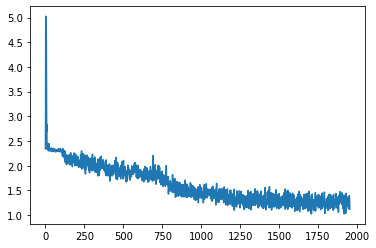

In [8]:
plt.plot(train_loss_tracker)

In [5]:
## Code Cell 1.4

torch.manual_seed(43) # to give stable randomness

# tracks the highest accuracy observed so far
best_acc = 0

def moving_average(a, n=100):
    '''Helper function used for visualization'''
    ret = torch.cumsum(torch.Tensor(a), 0)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def train(epoch, train_loss_tracker, train_acc_tracker):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        # update optimizer state
        optimizer.step()
        # compute average loss
        train_loss += loss.item()
        train_loss_tracker.append(loss.item())
        loss = train_loss / (batch_idx + 1)
        # compute accuracy
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        acc = 100. * correct / total
        # Print status
        sys.stdout.write(f'\rEpoch {epoch}: Train Loss: {loss:.3f}' +  
                         f'| Train Acc: {acc:.3f}')
        sys.stdout.flush()
    train_acc_tracker.append(acc)
    sys.stdout.flush()

def test(epoch, test_loss_tracker, test_acc_tracker):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            test_loss_tracker.append(loss.item())
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            loss = test_loss / (batch_idx + 1)
            acc = 100.* correct / total
    sys.stdout.write(f' | Test Loss: {loss:.3f} | Test Acc: {acc:.3f}\n')
    sys.stdout.flush()
    
    # Save checkpoint.
    acc = 100.*correct/total
    test_acc_tracker.append(acc)
    if acc > best_acc:
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc

device = 'cuda'# 'cuda'
net = ConvNet()
net = net.to(device)

# Implement: PART 1.1: set the learning rate (lr) used in the optimizer.
lr = 0.1

# Implement: PART 1.2: Why we use this milestone?
milestones = [2,3,5]

# Implement: PART 1.1: Modify this to train for a short 5 epochs
epochs = 5

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,
                            weight_decay=5e-4)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                 milestones=milestones,
                                                 gamma=0.1)

# Records the training loss and training accuracy during training
train_loss_tracker, train_acc_tracker = [], []

# Records the test loss and test accuracy during training
test_loss_tracker, test_acc_tracker = [], []

print('Training for {} epochs, with learning rate {} and milestones {}'.format(
      epochs, lr, milestones))

start_time = time.time()
for epoch in range(0, epochs):
    train(epoch, train_loss_tracker, train_acc_tracker)
    test(epoch, test_loss_tracker, test_acc_tracker)
    scheduler.step()

total_time = time.time() - start_time
print('Total training time: {} seconds'.format(total_time))


Training for 5 epochs, with learning rate 0.1 and milestones [2, 3, 5]
Epoch 0: Train Loss: 1.627| Train Acc: 39.500 | Test Loss: 1.398 | Test Acc: 50.610
Epoch 1: Train Loss: 1.152| Train Acc: 58.298 | Test Loss: 1.251 | Test Acc: 57.200
Epoch 2: Train Loss: 0.837| Train Acc: 70.246 | Test Loss: 0.807 | Test Acc: 71.650
Epoch 3: Train Loss: 0.770| Train Acc: 72.754 | Test Loss: 0.768 | Test Acc: 72.860
Epoch 4: Train Loss: 0.759| Train Acc: 73.012 | Test Loss: 0.758 | Test Acc: 73.090
Total training time: 89.44211268424988 seconds


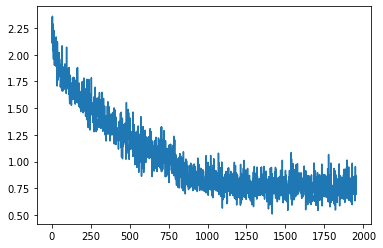

In [6]:
plt.plot(train_loss_tracker)

In [7]:
## Code Cell 1.4

torch.manual_seed(43) # to give stable randomness

# tracks the highest accuracy observed so far
best_acc = 0

def moving_average(a, n=100):
    '''Helper function used for visualization'''
    ret = torch.cumsum(torch.Tensor(a), 0)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def train(epoch, train_loss_tracker, train_acc_tracker):
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        # update optimizer state
        optimizer.step()
        # compute average loss
        train_loss += loss.item()
        train_loss_tracker.append(loss.item())
        loss = train_loss / (batch_idx + 1)
        # compute accuracy
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        acc = 100. * correct / total
        # Print status
        sys.stdout.write(f'\rEpoch {epoch}: Train Loss: {loss:.3f}' +  
                         f'| Train Acc: {acc:.3f}')
        sys.stdout.flush()
    train_acc_tracker.append(acc)
    sys.stdout.flush()

def test(epoch, test_loss_tracker, test_acc_tracker):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            test_loss_tracker.append(loss.item())
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            loss = test_loss / (batch_idx + 1)
            acc = 100.* correct / total
    sys.stdout.write(f' | Test Loss: {loss:.3f} | Test Acc: {acc:.3f}\n')
    sys.stdout.flush()
    
    # Save checkpoint.
    acc = 100.*correct/total
    test_acc_tracker.append(acc)
    if acc > best_acc:
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc

device = 'cuda'# 'cuda'
net = ConvNet()
net = net.to(device)

# Implement: PART 1.1: set the learning rate (lr) used in the optimizer.
lr = 0.0001

# Implement: PART 1.2: Why we use this milestone?
milestones = [2,3,5]

# Implement: PART 1.1: Modify this to train for a short 5 epochs
epochs = 5

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9,
                            weight_decay=5e-4)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                 milestones=milestones,
                                                 gamma=0.1)

# Records the training loss and training accuracy during training
train_loss_tracker, train_acc_tracker = [], []

# Records the test loss and test accuracy during training
test_loss_tracker, test_acc_tracker = [], []

print('Training for {} epochs, with learning rate {} and milestones {}'.format(
      epochs, lr, milestones))

start_time = time.time()
for epoch in range(0, epochs):
    train(epoch, train_loss_tracker, train_acc_tracker)
    test(epoch, test_loss_tracker, test_acc_tracker)
    scheduler.step()

total_time = time.time() - start_time
print('Total training time: {} seconds'.format(total_time))

Training for 5 epochs, with learning rate 0.0001 and milestones [2, 3, 5]
Epoch 0: Train Loss: 2.187| Train Acc: 18.682 | Test Loss: 2.045 | Test Acc: 25.720
Epoch 1: Train Loss: 1.994| Train Acc: 26.942 | Test Loss: 1.910 | Test Acc: 29.230
Epoch 2: Train Loss: 1.930| Train Acc: 28.922 | Test Loss: 1.899 | Test Acc: 29.420
Epoch 3: Train Loss: 1.925| Train Acc: 29.010 | Test Loss: 1.899 | Test Acc: 29.550
Epoch 4: Train Loss: 1.925| Train Acc: 29.050 | Test Loss: 1.898 | Test Acc: 29.590
Total training time: 89.4378433227539 seconds


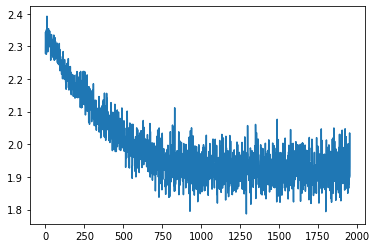

In [8]:
plt.plot(train_loss_tracker)